<Body>   
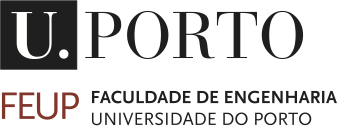   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split

## Data preprocessing

In [2]:
#df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

In [3]:
class FraudDataset(Dataset):
 
  def __init__(self, path, fraud = True):
    scaler = StandardScaler()
    df = pd.read_csv(path)
    if fraud:
      df = df[df['Class'] == 1]
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    #y = np.reshape(y, (1,-1))
    
    # Standardize data
    #x = scaler.fit_transform(x)
    #y = scaler.fit_transform(y)

    # Normalize data
    x = normalize(x)

    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)
    
  def __len__(self):
    return len(self.x_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset('creditcard.csv', fraud = True)

In [4]:
def split_dataset(data, split_size):

  if not isinstance(split_size, float):
    raise TypeError("split_size must be a float")

  # divide dataset into train-test subsets
  indices = list(range(len(data)))
  np.random.shuffle(indices, )

  data_size = split_size * len(indices)
  split = int(np.floor(data_size))
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  print(f'Training size: {len(train_idx)} \nTest size: {len(test_idx)}')

  return train_sampler, test_sampler


train, test = split_dataset(creditData.x_data, 0.2)

Training size: 394 
Test size: 98


In [5]:
train_dataloader = DataLoader(creditData, batch_size=64, sampler=train)
test_dataloader = DataLoader(creditData, batch_size=64, sampler=test)

In [6]:
# class myDataset(Dataset):
#     def __init__(self, path):
#         df = pd.read_csv(path)
#         df_fraud = df[df['Class'] == 1]
#         df_non_fraud = df[df['Class'] == 0]

#         # Split features and labels before splitting into train and test
#         x_fraud = df_fraud.drop(['Class'], axis=1)
#         y_fraud = df_fraud['Class']
#         x_non_fraud = df_non_fraud.drop(['Class'], axis=1)
#         y_non_fraud = df_non_fraud['Class']

#         # Create training and test dataset from df_fraud and df_non_fraud
#         train_size_fraud = int(0.8 * len(df_fraud))
#         test_size_fraud = len(df_fraud) - train_size_fraud

#         train_size_non_fraud = int(0.8 * len(df_non_fraud))
#         test_size_non_fraud = len(df_non_fraud) - train_size_non_fraud

#         # Combine features and labels and convert to list of tuples
#         fraud_data = list(zip(x_fraud.values, y_fraud.values))
#         non_fraud_data = list(zip(x_non_fraud.values, y_non_fraud.values))

#         #convert fraud_data and non_fraud_data to tensors
#         # fraud_data = torch.tensor(fraud_data)
#         # non_fraud_data = torch.tensor(non_fraud_data)


#         # Split the data
#         self.train_fraud, self.test_fraud = torch.utils.data.random_split(fraud_data, [train_size_fraud, test_size_fraud])
#         self.train_non_fraud, self.test_non_fraud = torch.utils.data.random_split(non_fraud_data, [train_size_non_fraud, test_size_non_fraud])

#         data = []
#         for i in range(len(self.train_fraud)):
#             teste = self.train_fraud[i]
#             # You might need to preprocess 'data' here, depending on your dataset's structure
#             data.append(teste)
#         self.train_fraud = data

#         # #convert to tensors
#         self.train_fraud = torch.tensor(self.train_fraud)
#         # self.test_fraud = torch.tensor(self.test_fraud)
#         # self.train_non_fraud = torch.tensor(self.train_non_fraud)
#         # self.test_non_fraud = torch.tensor(self.test_non_fraud)

#     def __len__(self):
#         return len(self.train_fraud)

#     def __getitem__(self, index):
#         return self.train_fraud[index], self.test_fraud[index], self.train_non_fraud[index], self.test_non_fraud[index]

# # Create dataset instance
# dataset = myDataset('/Users/henriqueribeiro/Downloads/creditcard.csv')


## Conditional Generative Adversarial Network

### Architecture

#### 1

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, nr_features)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
           nn.Linear(nr_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            #nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            #nn.Dropout2d(0.2),
            #nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            #nn.Dropout2d(0.2),
            #nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            #nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace = True),
            #nn.Dropout2d(0.2),
            #nn.Dropout(0.2),
            
            nn.Linear(32, 16),
            nn.ReLU(inplace = True),
            #nn.Dropout2d(0.2),
            #nn.Dropout(0.2),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

#### 2

In [9]:
class Generator2(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, nr_features),
            nn.ReLU()
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [10]:
class Discriminator2(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nr_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.ReLU()
        )
           
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [11]:
def get_models(arch):
    #define device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} device")

    if arch == 1:
        latent_dim = 7
        nr_features = 30

        #create optimizer for the generator
        generator = Generator(latent_dim, nr_features).to(device)
        generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

        #create optimizer for the descriminator
        discriminator = Discriminator(nr_features)
        discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

        print('\nArchitecture 1')
    else:
        latent_dim = 50
        nr_features = 30

        #create optimizer for the generator
        generator = Generator2(latent_dim, nr_features).to(device)
        generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

        #create optimizer for the descriminator
        discriminator = Discriminator2(nr_features)
        discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

        print('\nArchitecture 2')


    return generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim, nr_features, device

In [12]:
generator, discriminator, generator_optimizer, discriminator_optimizer, latent_dim, nr_features, device = get_models(1)

Using cpu device



Architecture 1


In [13]:
# #define device
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# latent_dim = 7
# nr_features = 30

# #create optimizer for the generator
# generator = Generator(latent_dim, nr_features).to(device)
# generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# #create optimizer for the descriminator
# discriminator = Discriminator(nr_features)
# discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# print(f"Using {device} device")


In [14]:
print('\t\t\tGenerator')
summary(generator, input_size=(latent_dim,))

			Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             128
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 32]             544
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 30]             990
Total params: 1,662
Trainable params: 1,662
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [15]:
print('\t\t\tDiscriminator')
summary(discriminator, input_size=(nr_features,))

			Discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          31,744
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
         Dropout2d-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
        Dropout2d-12                   [-1, 64]               0
           Linear-13                   [-1, 32]           2,080
             ReLU-14  

/Users/vp/anaconda3/envs/mdse/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


####  Loss Function + Device + Reset Gradients Funct.

In [16]:
#define device
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# def reset_grad():
#     discriminator_optimizer.zero_grad()
#     generator_optimizer.zero_grad()

criterion = nn.BCELoss()

In [17]:
def train_generator(opt_g, cur_batch_size, criterion):
    # Clear generator gradients
    opt_g.zero_grad()
    
   
    fake_targets = torch.ones((cur_batch_size),  device = device)
    
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    g_loss = criterion(fake_preds, fake_targets)

    g_loss.backward()
    opt_g.step()
    
    return g_loss, generated_data

In [18]:
def train_discriminator(real_data, opt_d, cur_batch_size):
    # Reset gradients
    opt_d.zero_grad()
    
   
    #real_labels = df_fraud['Class'].to_numpy() #sendo que estamos 
    
    #real_labels = torch.ones((cur_batch_size), device=device)
    real_labels = torch.rand((cur_batch_size), device=device) * 0.1 + 0.9
    real_preds = discriminator(real_data).reshape(-1)
    d_loss_real = criterion(real_preds, real_labels)
    
    fake_labels = torch.zeros((cur_batch_size),  device = device)
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    d_loss_fake = criterion(fake_preds, fake_labels)
    
    loss = (d_loss_real + d_loss_fake) / 2

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
        
    return loss

In [19]:
def train_gan(num_epochs):
    losses_gen = []
    losses_dis = []
    total_step = len(train_dataloader)
    print('Start training...')
    for epoch in range(num_epochs):
        for index, (real_data, real_labels) in enumerate(tqdm(train_dataloader)):
            cur_batch_size = real_data.shape[0]
            # Train generator and discriminator
            gen_loss, generated_data = train_generator(generator_optimizer, cur_batch_size, criterion)
            #print(f'Generator loss: {gen_loss:.3f}')
            dis_loss = train_discriminator(real_data, discriminator_optimizer, cur_batch_size)
            #print(f'Discriminator loss {dis_loss:.3f}')

            losses_gen.append(gen_loss)
            losses_dis.append(dis_loss)

        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch+1, num_epochs, index+1, total_step, dis_loss.item(), gen_loss.item()))
            
    return losses_gen, losses_dis, generated_data



In [20]:
losses_gen, losses_dis, generated_data = train_gan(200)

Start training...


 43%|████▎     | 3/7 [00:00<00:00, 14.46it/s]

100%|██████████| 7/7 [00:00<00:00, 14.53it/s]


Epoch [1/200], Step [7/7], d_loss: 0.7363, g_loss: 0.4737 



100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch [2/200], Step [7/7], d_loss: 0.7353, g_loss: 0.4775 



100%|██████████| 7/7 [00:00<00:00, 26.94it/s]


Epoch [3/200], Step [7/7], d_loss: 0.7278, g_loss: 0.4853 



100%|██████████| 7/7 [00:00<00:00, 23.21it/s]


Epoch [4/200], Step [7/7], d_loss: 0.7156, g_loss: 0.5028 



100%|██████████| 7/7 [00:00<00:00, 30.68it/s]


Epoch [5/200], Step [7/7], d_loss: 0.6837, g_loss: 0.5428 



100%|██████████| 7/7 [00:00<00:00, 33.28it/s]


Epoch [6/200], Step [7/7], d_loss: 0.6176, g_loss: 0.6212 



100%|██████████| 7/7 [00:00<00:00, 29.01it/s]


Epoch [7/200], Step [7/7], d_loss: 0.5827, g_loss: 0.6802 



100%|██████████| 7/7 [00:00<00:00, 29.38it/s]


Epoch [8/200], Step [7/7], d_loss: 0.5617, g_loss: 0.6923 



100%|██████████| 7/7 [00:00<00:00, 37.02it/s]


Epoch [9/200], Step [7/7], d_loss: 0.5433, g_loss: 0.6928 



100%|██████████| 7/7 [00:00<00:00, 33.74it/s]


Epoch [10/200], Step [7/7], d_loss: 0.5339, g_loss: 0.6927 



100%|██████████| 7/7 [00:00<00:00, 31.09it/s]


Epoch [11/200], Step [7/7], d_loss: 0.5260, g_loss: 0.6929 



100%|██████████| 7/7 [00:00<00:00, 34.07it/s]


Epoch [12/200], Step [7/7], d_loss: 0.5217, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.63it/s]


Epoch [13/200], Step [7/7], d_loss: 0.5248, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.62it/s]


Epoch [14/200], Step [7/7], d_loss: 0.5331, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.56it/s]


Epoch [15/200], Step [7/7], d_loss: 0.5304, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.59it/s]


Epoch [16/200], Step [7/7], d_loss: 0.5244, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.97it/s]


Epoch [17/200], Step [7/7], d_loss: 0.5356, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 24.61it/s]


Epoch [18/200], Step [7/7], d_loss: 0.5281, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.05it/s]


Epoch [19/200], Step [7/7], d_loss: 0.5286, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.01it/s]


Epoch [20/200], Step [7/7], d_loss: 0.5205, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.20it/s]


Epoch [21/200], Step [7/7], d_loss: 0.5219, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.31it/s]


Epoch [22/200], Step [7/7], d_loss: 0.5177, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.95it/s]


Epoch [23/200], Step [7/7], d_loss: 0.5293, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.64it/s]


Epoch [24/200], Step [7/7], d_loss: 0.5273, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


Epoch [25/200], Step [7/7], d_loss: 0.5291, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 27.21it/s]


Epoch [26/200], Step [7/7], d_loss: 0.5244, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 27.24it/s]


Epoch [27/200], Step [7/7], d_loss: 0.5305, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.06it/s]


Epoch [28/200], Step [7/7], d_loss: 0.5280, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 28.31it/s]


Epoch [29/200], Step [7/7], d_loss: 0.5267, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.74it/s]


Epoch [30/200], Step [7/7], d_loss: 0.5204, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.40it/s]


Epoch [31/200], Step [7/7], d_loss: 0.5345, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.29it/s]


Epoch [32/200], Step [7/7], d_loss: 0.5302, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 28.13it/s]


Epoch [33/200], Step [7/7], d_loss: 0.5251, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.64it/s]


Epoch [34/200], Step [7/7], d_loss: 0.5159, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.54it/s]


Epoch [35/200], Step [7/7], d_loss: 0.5265, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.95it/s]


Epoch [36/200], Step [7/7], d_loss: 0.5323, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.29it/s]


Epoch [37/200], Step [7/7], d_loss: 0.5266, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.78it/s]


Epoch [38/200], Step [7/7], d_loss: 0.5273, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.93it/s]


Epoch [39/200], Step [7/7], d_loss: 0.5272, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.53it/s]


Epoch [40/200], Step [7/7], d_loss: 0.5279, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.94it/s]


Epoch [41/200], Step [7/7], d_loss: 0.5274, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.07it/s]


Epoch [42/200], Step [7/7], d_loss: 0.5311, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.67it/s]


Epoch [43/200], Step [7/7], d_loss: 0.5250, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.62it/s]


Epoch [44/200], Step [7/7], d_loss: 0.5277, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.79it/s]


Epoch [45/200], Step [7/7], d_loss: 0.5380, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.16it/s]


Epoch [46/200], Step [7/7], d_loss: 0.5238, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.27it/s]


Epoch [47/200], Step [7/7], d_loss: 0.5309, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 28.76it/s]


Epoch [48/200], Step [7/7], d_loss: 0.5302, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 41.03it/s]


Epoch [49/200], Step [7/7], d_loss: 0.5319, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.56it/s]


Epoch [50/200], Step [7/7], d_loss: 0.5227, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.69it/s]


Epoch [51/200], Step [7/7], d_loss: 0.5324, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.65it/s]


Epoch [52/200], Step [7/7], d_loss: 0.5283, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.70it/s]


Epoch [53/200], Step [7/7], d_loss: 0.5248, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.71it/s]


Epoch [54/200], Step [7/7], d_loss: 0.5205, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.44it/s]


Epoch [55/200], Step [7/7], d_loss: 0.5261, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 26.04it/s]


Epoch [56/200], Step [7/7], d_loss: 0.5325, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.19it/s]


Epoch [57/200], Step [7/7], d_loss: 0.5212, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.82it/s]


Epoch [58/200], Step [7/7], d_loss: 0.5313, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.13it/s]


Epoch [59/200], Step [7/7], d_loss: 0.5326, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.47it/s]


Epoch [60/200], Step [7/7], d_loss: 0.5354, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.63it/s]


Epoch [61/200], Step [7/7], d_loss: 0.5298, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 21.32it/s]


Epoch [62/200], Step [7/7], d_loss: 0.5287, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.73it/s]


Epoch [63/200], Step [7/7], d_loss: 0.5316, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.73it/s]


Epoch [64/200], Step [7/7], d_loss: 0.5300, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.00it/s]


Epoch [65/200], Step [7/7], d_loss: 0.5272, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.42it/s]


Epoch [66/200], Step [7/7], d_loss: 0.5368, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.47it/s]


Epoch [67/200], Step [7/7], d_loss: 0.5342, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.66it/s]


Epoch [68/200], Step [7/7], d_loss: 0.5324, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.43it/s]


Epoch [69/200], Step [7/7], d_loss: 0.5338, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.66it/s]


Epoch [70/200], Step [7/7], d_loss: 0.5247, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.99it/s]


Epoch [71/200], Step [7/7], d_loss: 0.5342, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.80it/s]


Epoch [72/200], Step [7/7], d_loss: 0.5255, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.69it/s]


Epoch [73/200], Step [7/7], d_loss: 0.5213, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.72it/s]


Epoch [74/200], Step [7/7], d_loss: 0.5248, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.32it/s]


Epoch [75/200], Step [7/7], d_loss: 0.5313, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.71it/s]


Epoch [76/200], Step [7/7], d_loss: 0.5219, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.28it/s]


Epoch [77/200], Step [7/7], d_loss: 0.5264, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.40it/s]


Epoch [78/200], Step [7/7], d_loss: 0.5216, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 41.22it/s]


Epoch [79/200], Step [7/7], d_loss: 0.5366, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 41.34it/s]


Epoch [80/200], Step [7/7], d_loss: 0.5275, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.59it/s]


Epoch [81/200], Step [7/7], d_loss: 0.5261, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.98it/s]


Epoch [82/200], Step [7/7], d_loss: 0.5222, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 41.53it/s]


Epoch [83/200], Step [7/7], d_loss: 0.5285, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.38it/s]


Epoch [84/200], Step [7/7], d_loss: 0.5315, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.33it/s]


Epoch [85/200], Step [7/7], d_loss: 0.5251, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.79it/s]


Epoch [86/200], Step [7/7], d_loss: 0.5291, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.93it/s]


Epoch [87/200], Step [7/7], d_loss: 0.5241, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 40.08it/s]


Epoch [88/200], Step [7/7], d_loss: 0.5283, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.63it/s]


Epoch [89/200], Step [7/7], d_loss: 0.5218, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.65it/s]


Epoch [90/200], Step [7/7], d_loss: 0.5305, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [91/200], Step [7/7], d_loss: 0.5347, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.54it/s]


Epoch [92/200], Step [7/7], d_loss: 0.5287, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.36it/s]


Epoch [93/200], Step [7/7], d_loss: 0.5213, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.94it/s]


Epoch [94/200], Step [7/7], d_loss: 0.5231, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.50it/s]


Epoch [95/200], Step [7/7], d_loss: 0.5220, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.52it/s]


Epoch [96/200], Step [7/7], d_loss: 0.5278, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.84it/s]


Epoch [97/200], Step [7/7], d_loss: 0.5351, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.29it/s]


Epoch [98/200], Step [7/7], d_loss: 0.5244, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.37it/s]


Epoch [99/200], Step [7/7], d_loss: 0.5244, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.09it/s]


Epoch [100/200], Step [7/7], d_loss: 0.5223, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.16it/s]


Epoch [101/200], Step [7/7], d_loss: 0.5202, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.24it/s]


Epoch [102/200], Step [7/7], d_loss: 0.5301, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.36it/s]


Epoch [103/200], Step [7/7], d_loss: 0.5241, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [104/200], Step [7/7], d_loss: 0.5342, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 26.43it/s]


Epoch [105/200], Step [7/7], d_loss: 0.5300, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.96it/s]


Epoch [106/200], Step [7/7], d_loss: 0.5331, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.18it/s]


Epoch [107/200], Step [7/7], d_loss: 0.5388, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.23it/s]


Epoch [108/200], Step [7/7], d_loss: 0.5267, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.15it/s]


Epoch [109/200], Step [7/7], d_loss: 0.5264, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.16it/s]


Epoch [110/200], Step [7/7], d_loss: 0.5345, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 27.57it/s]


Epoch [111/200], Step [7/7], d_loss: 0.5281, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.64it/s]


Epoch [112/200], Step [7/7], d_loss: 0.5278, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.01it/s]


Epoch [113/200], Step [7/7], d_loss: 0.5248, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.54it/s]


Epoch [114/200], Step [7/7], d_loss: 0.5262, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 30.82it/s]


Epoch [115/200], Step [7/7], d_loss: 0.5261, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.22it/s]


Epoch [116/200], Step [7/7], d_loss: 0.5307, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 27.69it/s]


Epoch [117/200], Step [7/7], d_loss: 0.5309, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.33it/s]


Epoch [118/200], Step [7/7], d_loss: 0.5267, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.56it/s]


Epoch [119/200], Step [7/7], d_loss: 0.5236, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.61it/s]


Epoch [120/200], Step [7/7], d_loss: 0.5275, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.04it/s]


Epoch [121/200], Step [7/7], d_loss: 0.5321, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.85it/s]


Epoch [122/200], Step [7/7], d_loss: 0.5239, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.31it/s]


Epoch [123/200], Step [7/7], d_loss: 0.5366, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.19it/s]


Epoch [124/200], Step [7/7], d_loss: 0.5327, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.48it/s]


Epoch [125/200], Step [7/7], d_loss: 0.5348, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.08it/s]


Epoch [126/200], Step [7/7], d_loss: 0.5264, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.65it/s]


Epoch [127/200], Step [7/7], d_loss: 0.5388, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.27it/s]


Epoch [128/200], Step [7/7], d_loss: 0.5294, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 21.56it/s]


Epoch [129/200], Step [7/7], d_loss: 0.5238, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.45it/s]


Epoch [130/200], Step [7/7], d_loss: 0.5256, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 30.07it/s]


Epoch [131/200], Step [7/7], d_loss: 0.5316, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 30.89it/s]


Epoch [132/200], Step [7/7], d_loss: 0.5267, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.60it/s]


Epoch [133/200], Step [7/7], d_loss: 0.5309, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.47it/s]


Epoch [134/200], Step [7/7], d_loss: 0.5298, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.04it/s]


Epoch [135/200], Step [7/7], d_loss: 0.5345, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.00it/s]


Epoch [136/200], Step [7/7], d_loss: 0.5259, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 30.01it/s]


Epoch [137/200], Step [7/7], d_loss: 0.5278, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.45it/s]


Epoch [138/200], Step [7/7], d_loss: 0.5215, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.82it/s]


Epoch [139/200], Step [7/7], d_loss: 0.5277, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 24.17it/s]


Epoch [140/200], Step [7/7], d_loss: 0.5271, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.72it/s]


Epoch [141/200], Step [7/7], d_loss: 0.5325, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.74it/s]


Epoch [142/200], Step [7/7], d_loss: 0.5324, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.41it/s]


Epoch [143/200], Step [7/7], d_loss: 0.5280, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.66it/s]


Epoch [144/200], Step [7/7], d_loss: 0.5276, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.66it/s]


Epoch [145/200], Step [7/7], d_loss: 0.5284, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.52it/s]


Epoch [146/200], Step [7/7], d_loss: 0.5252, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.92it/s]


Epoch [147/200], Step [7/7], d_loss: 0.5182, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.70it/s]


Epoch [148/200], Step [7/7], d_loss: 0.5324, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.39it/s]


Epoch [149/200], Step [7/7], d_loss: 0.5264, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.45it/s]


Epoch [150/200], Step [7/7], d_loss: 0.5294, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.11it/s]


Epoch [151/200], Step [7/7], d_loss: 0.5206, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.70it/s]


Epoch [152/200], Step [7/7], d_loss: 0.5326, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 27.78it/s]


Epoch [153/200], Step [7/7], d_loss: 0.5262, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.00it/s]


Epoch [154/200], Step [7/7], d_loss: 0.5314, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.32it/s]


Epoch [155/200], Step [7/7], d_loss: 0.5219, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.32it/s]


Epoch [156/200], Step [7/7], d_loss: 0.5261, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 39.12it/s]


Epoch [157/200], Step [7/7], d_loss: 0.5347, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.88it/s]


Epoch [158/200], Step [7/7], d_loss: 0.5249, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.11it/s]


Epoch [159/200], Step [7/7], d_loss: 0.5292, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.27it/s]


Epoch [160/200], Step [7/7], d_loss: 0.5256, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.70it/s]


Epoch [161/200], Step [7/7], d_loss: 0.5298, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.58it/s]


Epoch [162/200], Step [7/7], d_loss: 0.5301, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [163/200], Step [7/7], d_loss: 0.5258, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.11it/s]


Epoch [164/200], Step [7/7], d_loss: 0.5294, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.50it/s]


Epoch [165/200], Step [7/7], d_loss: 0.5334, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 23.77it/s]


Epoch [166/200], Step [7/7], d_loss: 0.5283, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.19it/s]


Epoch [167/200], Step [7/7], d_loss: 0.5313, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.60it/s]


Epoch [168/200], Step [7/7], d_loss: 0.5230, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.78it/s]


Epoch [169/200], Step [7/7], d_loss: 0.5418, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 36.32it/s]


Epoch [170/200], Step [7/7], d_loss: 0.5325, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 17.56it/s]


Epoch [171/200], Step [7/7], d_loss: 0.5273, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 16.33it/s]


Epoch [172/200], Step [7/7], d_loss: 0.5292, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 19.90it/s]


Epoch [173/200], Step [7/7], d_loss: 0.5300, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 28.70it/s]


Epoch [174/200], Step [7/7], d_loss: 0.5261, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.27it/s]


Epoch [175/200], Step [7/7], d_loss: 0.5321, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 22.52it/s]


Epoch [176/200], Step [7/7], d_loss: 0.5295, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.44it/s]


Epoch [177/200], Step [7/7], d_loss: 0.5251, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.55it/s]


Epoch [178/200], Step [7/7], d_loss: 0.5295, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 37.18it/s]


Epoch [179/200], Step [7/7], d_loss: 0.5297, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.58it/s]


Epoch [180/200], Step [7/7], d_loss: 0.5244, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 38.07it/s]


Epoch [181/200], Step [7/7], d_loss: 0.5322, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 32.98it/s]


Epoch [182/200], Step [7/7], d_loss: 0.5316, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 26.45it/s]


Epoch [183/200], Step [7/7], d_loss: 0.5317, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.56it/s]


Epoch [184/200], Step [7/7], d_loss: 0.5336, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.53it/s]


Epoch [185/200], Step [7/7], d_loss: 0.5335, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 35.16it/s]


Epoch [186/200], Step [7/7], d_loss: 0.5324, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.64it/s]


Epoch [187/200], Step [7/7], d_loss: 0.5280, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.02it/s]


Epoch [188/200], Step [7/7], d_loss: 0.5356, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 34.15it/s]


Epoch [189/200], Step [7/7], d_loss: 0.5326, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 24.52it/s]


Epoch [190/200], Step [7/7], d_loss: 0.5205, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.74it/s]


Epoch [191/200], Step [7/7], d_loss: 0.5255, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 24.24it/s]


Epoch [192/200], Step [7/7], d_loss: 0.5202, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 26.53it/s]


Epoch [193/200], Step [7/7], d_loss: 0.5277, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.42it/s]


Epoch [194/200], Step [7/7], d_loss: 0.5348, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


Epoch [195/200], Step [7/7], d_loss: 0.5317, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 23.98it/s]


Epoch [196/200], Step [7/7], d_loss: 0.5249, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 31.33it/s]


Epoch [197/200], Step [7/7], d_loss: 0.5231, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 29.65it/s]


Epoch [198/200], Step [7/7], d_loss: 0.5271, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 33.39it/s]


Epoch [199/200], Step [7/7], d_loss: 0.5307, g_loss: 0.6931 



100%|██████████| 7/7 [00:00<00:00, 24.02it/s]

Epoch [200/200], Step [7/7], d_loss: 0.5278, g_loss: 0.6931 



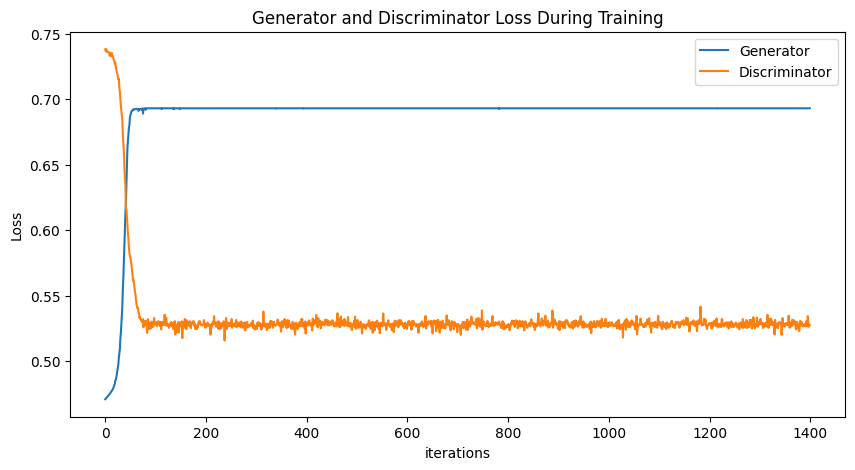

In [21]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.detach().numpy() for i in losses_gen]
    losses_dis = [i.detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

### Model evaluation